# TM10007 Assignment: Prediction of Tumor Grade in Brain Cancer

Group 4: Kiefer Comassi (4402359), Myrthe van Haaften (4547470), Frédérique Koopman (4470885), Stephanie Stoutjesdijk (4557808)


## Installing and importing functions and packages

In [36]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git
#!pip install missingpy

In [37]:
import numpy as np
import pandas as pd
from math import floor
import matplotlib.pyplot as plt

from scipy.stats import shapiro
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from missingpy import KNNImputer
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn import svm

from brats.load_data import load_data

## Loading and splitting data 

In [38]:
# Load data
data = load_data()

# Splitting feature values and patient labels
FEATURES = data.drop(columns=['label'])
LABELS = data['label']

GBM = FEATURES.loc[LABELS=='GBM']
LGG = FEATURES.loc[LABELS=='LGG']

# Splitting into train and test set --> dit moet weg
#X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(FEATURES, LABELS, test_size=0.2, random_state=42)



## Preprocessing before crossvalidation

Overview of the NaN's in the dataset

In [39]:
# Determining the number of NaN's
NO_NAN_ROW_TOTAL = FEATURES.isnull().sum(axis=1)             # Number of NaN's per patient for GBM and LGG patients
NO_NAN_COL_TOTAL = FEATURES.isnull().sum(axis=0)             # Number of NaN's per feature for GBM and LGG patients

GBM_NO_NAN_COL = GBM.isnull().sum(axis=0)                    # Number of NaN's per feature for GBM patients
LGG_NO_NAN_COL = LGG.isnull().sum(axis=0)                    # Number of NaN's per feature for LGG patients
OVERVIEW_NAN = { 'Total': NO_NAN_COL_TOTAL, 'GBM': GBM_NO_NAN_COL, 'LGG': LGG_NO_NAN_COL } 


Feature selection based on the number of NaN's. Threshold = the maximum number of NaN's in a column

In [40]:
# Define percentage of patients with no data for a certain feature, above which the feature is discarded
PERC_MISSING_GBM = 30
PERC_MISSING_LGG = 30

# Determining threshold for discarding feature based on above percentage
THRESHOLD_GBM = floor((PERC_MISSING_GBM/100) * len(GBM.index))
THRESHOLD_LGG = floor((PERC_MISSING_LGG/100) * len(LGG.index))

# Initialisation
FEATURES_REMOVED = []

# Append names of features that should be discarded to list

for feature in GBM_NO_NAN_COL[GBM_NO_NAN_COL > THRESHOLD_GBM].index[:]:
    FEATURES_REMOVED.append(feature)

for feature in LGG_NO_NAN_COL[LGG_NO_NAN_COL > THRESHOLD_LGG].index[:]:
    FEATURES_REMOVED.append(feature)

# Remove features from dataset
DATA_FEAT_SEL = FEATURES.drop(columns=[features for features in set(FEATURES_REMOVED)])

# The variables (series) below 'bins' the NaN's:
# - the index column is the amount of NaN's in the dataset 
# - the second column is the amount of features that have this amount of NaN's

#aantal_NAN_GBM = GBM_no_nan_col.value_counts()
#aantal_NAN_LGG = LGG_no_nan_col.value_counts()
#aantal_NAN_total = no_nan_col.value_counts()


Patient selection based on the number of NaN's. Threshold = the maximum number of NaN's in a row.

In [41]:
# Patient selection 

# Percentage/number of features that a patient is allowed to miss. When above this amount, this patient is removed from the trainingset, because it is missing too many features. 
PERC_MISSING_SAMPLE = 30

# Make the threshold
THRESHOLD_SAMPLE = floor((PERC_MISSING_SAMPLE/100) * len(DATA_FEAT_SEL.columns))

# Number of NaN's per patient AFTER removing some features
NO_NAN_ROW_TRAIN = DATA_FEAT_SEL.isnull().sum(axis=1)      

# Make an empty list, which will be filled with samples that are above the threshold
SAMPLES_REMOVED = [] 
LABELS_SEL = LABELS

# Looping over the trainingset to determine which patients are above the threshold, and remove them directly.
#print('These samples are removed from dataset:')
#for sample in NO_NAN_ROW_TRAIN[NO_NAN_ROW_TRAIN > THRESHOLD_SAMPLE].index[:]:
#    if sample:
#        print(sample)
#        SAMPLES_REMOVED.append(sample)      # This should be removed in combination with the comment before
#        DATA_FEAT_SEL = DATA_FEAT_SEL.drop(index=sample)
#        LABELS_SEL = LABELS_SEL.drop(index=sample)

#print(f'{len(DATA_FEAT_SEL)}/{len(FEATURES)} samples are left in dataset')

Evaluation of data distribution and outliers

In [42]:
# Evaluate data distribution: 
IMPUTER_TOTAL = KNNImputer(n_neighbors=5, weights="uniform")

DATA_TOTAL_IMPUTED = IMPUTER_TOTAL.fit_transform(DATA_FEAT_SEL)

NO_NORM_DISTR = 0
FEAT_NORM = list()
for index, feature in enumerate(DATA_TOTAL_IMPUTED.T):
    t_stat, p_value = shapiro(feature)
    if p_value>0.05:
        NO_NORM_DISTR += 1 
        FEAT_NORM.append(index)



In [43]:

# Evaluate per patient each feature
NO_OUTLIERS = 0

for patient in DATA_TOTAL_IMPUTED:
    feat_out = 0
    for index, feature in enumerate(patient):
        q25, q75 = np.percentile(DATA_TOTAL_IMPUTED[:,index], 25), np.percentile(DATA_TOTAL_IMPUTED[:,index], 75)
        iqr = q75 - q25
        cut_off = iqr * 1.5
        lower, upper = q25 - cut_off, q75 + cut_off
        outlier = ((feature>upper) | (feature<lower))
        feat_out += outlier
    if feat_out > 70:
        NO_OUTLIERS += 1

# Calculate mean and standard deviation per feature based on training data
#MEAN = DATA_TOTAL_IMPUTED.mean(axis=0)
#STD = DATA_TOTAL_IMPUTED.std(axis=0)

# Evaluate per patient each feature
#NO_OUTLIERS = 0
#for patient in DATA_TOTAL_IMPUTED:
#    feat_out = 0
#    for feature, mu, std in zip(patient, MEAN, STD):
#        outlier = ((feature>mu+3*std) | (feature<mu-3*std))
#        feat_out += outlier
#    if feat_out > 30:
#        no_outliers += 1

## Crossvalidation 

Optimal number of features : 2


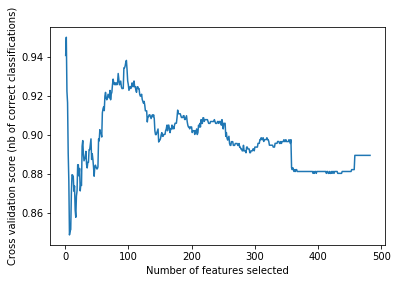

Optimal number of features : 4


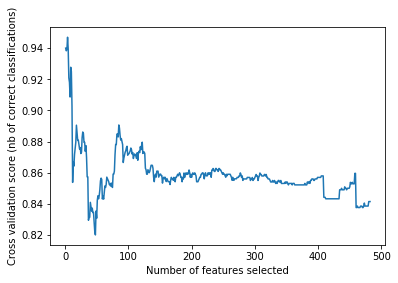

Optimal number of features : 61


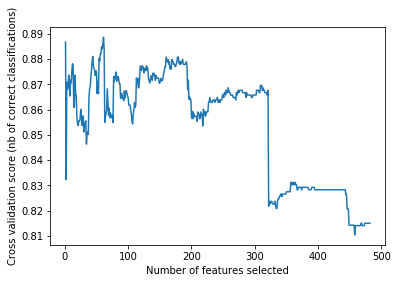

Optimal number of features : 1


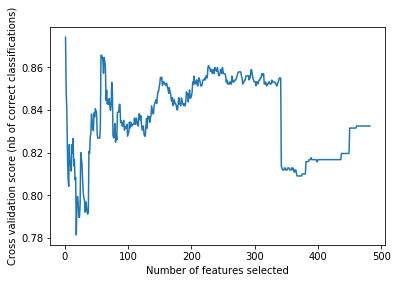

Optimal number of features : 221


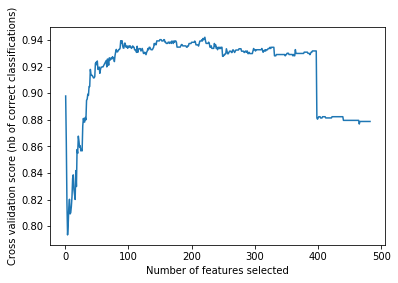

In [48]:
# Outer crossvalidation loop
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

OPTIMAL_NUMBER_FEATURES = list()

for train_index, test_index in skf.split(DATA_FEAT_SEL, LABELS_SEL):
    X_TRAIN, X_TEST = np.array(DATA_FEAT_SEL)[train_index], np.array(DATA_FEAT_SEL)[test_index]
    Y_TRAIN, Y_TEST = np.array(LABELS_SEL)[train_index], np.array(LABELS_SEL)[test_index]

    GBM_TRAIN = X_TRAIN[Y_TRAIN=='GBM']
    LGG_TRAIN = X_TRAIN[Y_TRAIN=='LGG']

    # ---------------------------------- IMPUTATION -----------------------------------
    # Definition of imputers
    IMPUTER_GBM = KNNImputer(n_neighbors=5, weights="uniform")
    IMPUTER_LGG = KNNImputer(n_neighbors=5, weights="uniform")        
    IMPUTER_TEST = KNNImputer(n_neighbors=5, weights="uniform")

    # Impute GBM train set
    X_TRAIN_FEAT_SEL_GBM = X_TRAIN[Y_TRAIN=='GBM']        
    X_TRAIN_IMP_GBM = IMPUTER_GBM.fit_transform(X_TRAIN_FEAT_SEL_GBM)    

    # Impute LGG train set
    X_TRAIN_FEAT_SEL_LGG = X_TRAIN[Y_TRAIN=='LGG']        
    X_TRAIN_IMP_LGG = IMPUTER_LGG.fit_transform(X_TRAIN_FEAT_SEL_LGG)    

    # Merge imputed GBM and LGG arrays
    X_TRAIN_IMP_TOT = np.concatenate((X_TRAIN_IMP_GBM, X_TRAIN_IMP_LGG))
                                        
    #LGG_IMPUTED[:] = ARRAY_IMP_LGG                                                      # Overwrite original values with imputed values in dataframe
    #LGG_IMPUTED['label'] = 'LGG'                                                        # Add column containing label

    # Impute test set 
    IMPUTER_TEST.fit(X_TRAIN_IMP_TOT)
    X_TEST_IMP = IMPUTER_TEST.transform(X_TEST)
 
    # ------------------------------------ SCALING ----------------------------------------
    SCALER = RobustScaler()
    SCALER.fit(X_TRAIN_IMP_TOT)
    X_TRAIN_SCAL = SCALER.transform(X_TRAIN_IMP_TOT)
    X_TEST_SCAL = SCALER.transform(X_TEST_IMP)


    # ------------------------------------ FEATURE SELECTION -------------------------------
    svc = svm.SVC(kernel="linear")

    # classifications
    rfecv = RFECV(
        estimator=svc, step=1, 
        cv=StratifiedKFold(4),
        scoring='roc_auc')
    rfecv.fit(X_TRAIN_SCAL, Y_TRAIN)                               

    OPTIMAL_NUMBER_FEATURES.append(rfecv.n_features_)
    print("Optimal number of features : %d" % rfecv.n_features_)

    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()

    X_TRAIN_FINAL = X_TRAIN_SCAL[:,rfecv.support_]
    X_TEST_FINAL = X_TEST_SCAL[:,rfecv.support_]
    #print(rfecv.ranking_)
#np.absolute(rfecv.estimator_.coef_)
